In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display
from IPython.display import Markdown as md
from scipy import stats

The authors of "A Data Mining Approach to Predict Forest Fires uning Meteorological Data" wanted to determine if environmental factors can be used in a predictive model to estimate burn areas caused by the fire.  My goal is to take the same data and explore the relationships between environmental factors and the frequency of fire events presented in the data set.
<ol>
    <li>Based on the data presented, is there a demonstrable link between burn area and environmental conditions?</li>
    <li>Does statistical analysis buttress or refute a relationship?</li>
    <li>Do the environmental factors have an impact on the burn area?</li>
</ol>

<p>
    <em>Source</em>: Cortez, Paulo & Morais, A. (2007). A Data Mining Approach to Predict Forest Fires using Meteorological Data.<br/> 
    The studay authors presented a data set with 517 enteries from the Montesinho natural park in northeast region of Portugal.  The data collected covers a three year period, from January 200 to December 2003.  There are 517 fire events represented in the data set.
</p>
<p>
    Variable definitions and ranges:<br>
    <ol>
       <li><em>X</em> (categorical) - x-axis spatial coordinate within the Montesinho park map: 1 to 9 </li>
       <li><em>Y</em> (categorical) - y-axis spatial coordinate within the Montesinho park map: 1 to 9</li>
       <li><em>month</em> (categorical) - month of the year: 'jan' to 'dec'</li>
       <li><em>day</em> (categorical) - day of the week: 'mon' to 'sun'</li>
       <li><em>FFMC</em> (continuous) - FFMC (Fine Fuel Moisture Code) index from the FWI system: 18.7 to 96.20</li>
       <li><em>DMC</em> (continuous) - DMC (Duff Moisture Code) index from the FWI system: 1.1 to 291.3</li>
       <li><em>DC</em> (continuous) - DC (Drought Code) index from the FWI system: 7.9 to 860.6</li>
       <li><em>ISI</em> (continuous) - ISI (Initial Spread Index) index from the FWI system: 0.0 to 56.10</li>
       <li><em>temp</em> (continuous) - temperature in Celsius degrees: 2.2 to 33.30</li>
       <li><em>RH</em> (contiuous) - relative humidity in %: 15.0 to 100</li>
       <li><em>wind</em> (continuous) - wind speed in km/h: 0.40 to 9.40</li>
       <li><em>rain</em> (continuous) - outside rain in mm/m2 : 0.0 to 6.4, accumulated percipitation within the previous 30 mins</li>
       <li><em>area</em> (continuous) - the burned area of the forest (in ha): 0.00 to 1090.84 (this output variable is very skewed towards 0.0, thus it may make sense to model with the logarithm transform).</li>
    </ol>
</p>

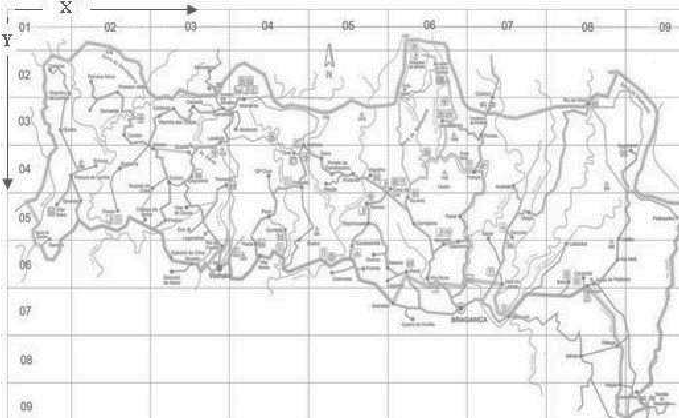

In [2]:
display(Image("The-map-of-the-Montesinho-natural-park.png"))

In [3]:
# Function to categorize the burn area as 'small', 'medium', or 'large'
def size(x): 
    if x < 0.52:
        return 'small'
    elif 0.52<= x < 6.57: 
        return 'medium'
    return 'large'

forest_fires = pd.read_csv('forestfires.csv')

forest_fires['fire_size'] = forest_fires['area'].apply(size)

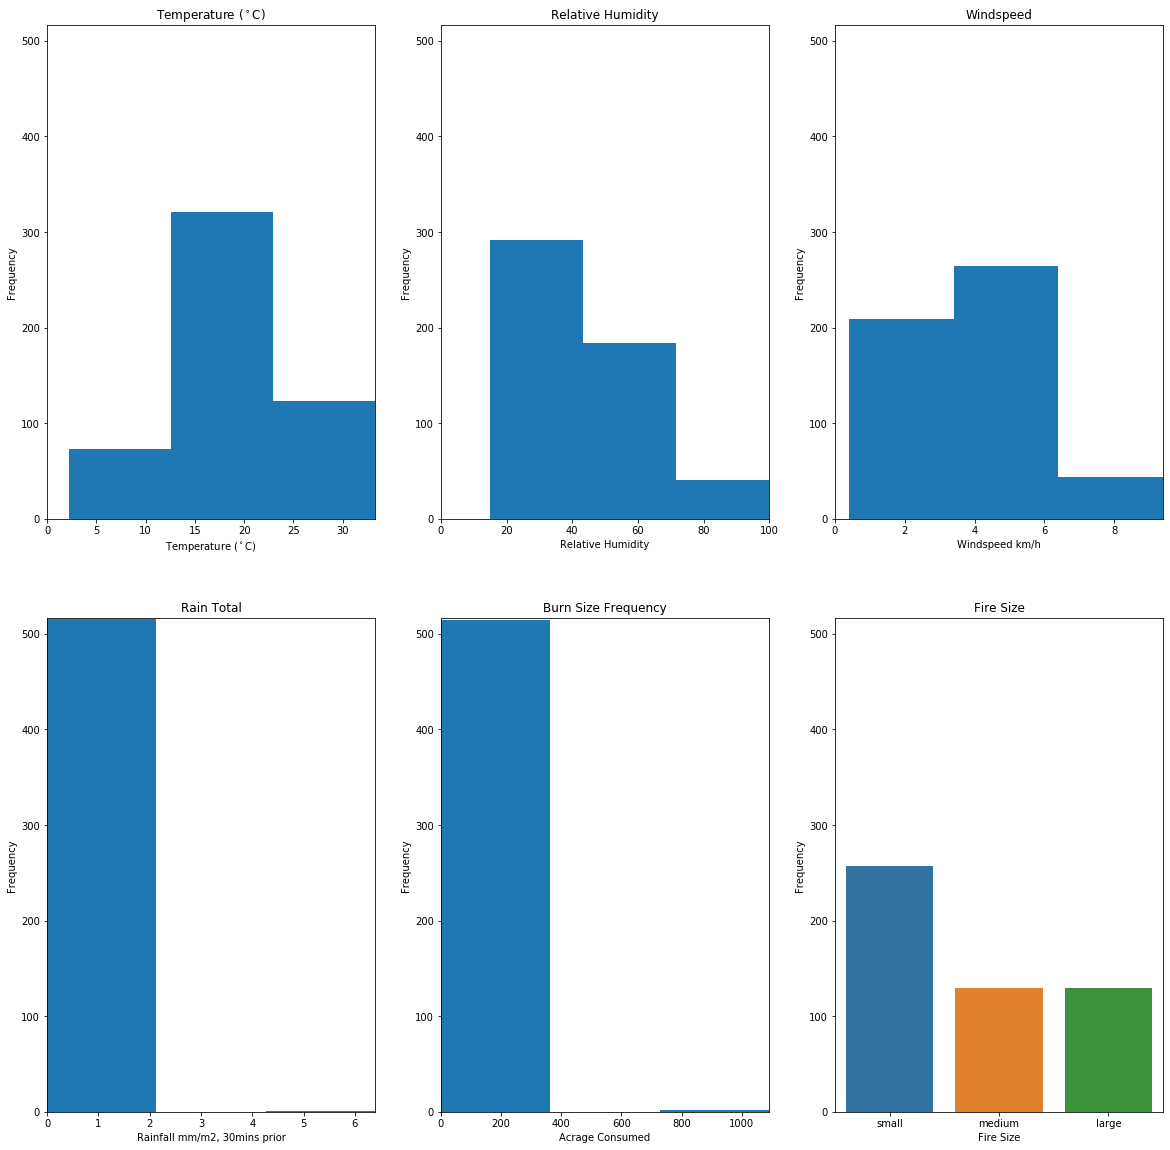


As it stands... 
<ul>
    <li>Most fires occured > 15&#8451;</li>
    <li>Most fires occured when Relative Humidity was < 70%</li>  
    <li>Most fires occured with windspeeds between 4 and 6 km/hr</li>
    <li>For most of the fire events there was little more than 2 mm/m2 within 30 min of the fire</li>
    <li>The overwhelming majority of fires area < 400 ha which introduces a lot of skewness in the data.</li>              
    <li>Small fires (< 0.52 ha) were the most common, so much so that removing outliers might provide better insight.</li>
</ul>


In [4]:
plt.figure(figsize=(20,20))

plt.subplot(2,3,1)
plt.hist(forest_fires['temp'],bins=3)
plt.xlabel('Temperature ($ ^\circ $C)')
plt.xlim(0,33.30)
plt.ylabel('Frequency')
plt.ylim(0,517)
plt.title('Temperature ($ ^\circ $C)')

plt.subplot(2,3,2)
plt.hist(forest_fires['RH'],bins=3)
plt.xlabel('Relative Humidity')
plt.xlim(0,100)
plt.ylabel('Frequency')
plt.ylim(0,517)
plt.title('Relative Humidity')

plt.subplot(2,3,3)
plt.hist(forest_fires['wind'],bins=3)
plt.xlabel('Windspeed km/h')
plt.xlim(0,9.40)
plt.ylabel('Frequency')
plt.ylim(0,517)
plt.title('Windspeed')

plt.subplot(2,3,4)
plt.hist(forest_fires['rain'],bins=3)
plt.xlabel('Rainfall mm/m2, 30mins prior')
plt.xlim(0,6.4)
plt.ylabel('Frequency')
plt.ylim(0,517)
plt.title('Rain Total')

plt.subplot(2,3,5)
plt.hist(forest_fires['area'],bins=3)
plt.xlabel('Acrage Consumed')
plt.xlim(0,1090.84)
plt.ylabel('Frequency')
plt.ylim(0,517)
plt.title('Burn Size Frequency')

plt.subplot(2,3,6)
sns.countplot(x='fire_size', data=forest_fires)
plt.xlabel('Fire Size')
plt.ylabel('Frequency')
plt.ylim(0,517)
plt.title('Fire Size')

plt.show()

md(f"""
As it stands... 
<ul>
    <li>Most fires occured > 15&#8451;</li>
    <li>Most fires occured when Relative Humidity was < 70%</li>  
    <li>Most fires occured with windspeeds between 4 and 6 km/hr</li>
    <li>For most of the fire events there was little more than 2 mm/m2 within 30 min of the fire</li>
    <li>The overwhelming majority of fires area < 400 ha which introduces a lot of skewness in the data.</li>              
    <li>Small fires (< 0.52 ha) were the most common, so much so that removing outliers might provide better insight.</li>
</ul>
""")

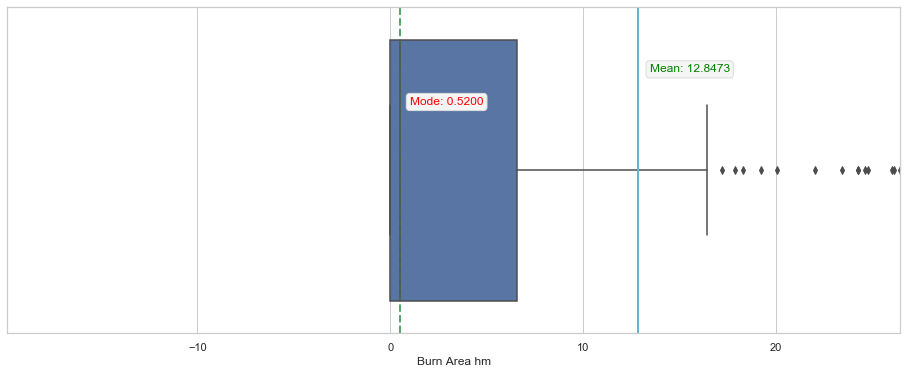


<p>
As presented the the data is heavily skewed to small fire sizes with 12% of fire events constituting the set of outliers.  
In an effort to normalize the data I used a 1.5x multiplier applied the Inter Quartile Range to establish an upper range limit.  
The table below summerizes the the data used establish the box plot above.
</p>
<p>
    <table>
        <tr>
            <td>Min Burn Area</td>
            <td>0.0</td>
        </tr>
        <tr>
            <td>Max Burn Area</td>
            <td>1090.84</td>
        </tr>
        <tr>
            <td>Burn Area Mode</td>
            <td>0.0</td>
        </tr>
        <tr>
            <td>Fire Size Mode</td>
            <td>small</td>
        </tr>
        <tr>
           <td>Burn Area Range</td>
           <td>1090.84</td> 
        </tr>
        <tr>
            <td>Q1</td>
            <td>0.0</td>
        </tr>
        <tr>
            <td>Q2 (Median)</td>
            <td>0.52</td>
        </tr>
        <tr>
            <td>Q3</td>
            <td>6.57</td>
        </tr>
        <tr>
            <td>IQR</td>
            <td>6.57</td>
        </tr>
        <tr>
            <td>Min Burn Area Fence</td>
            <td>-9.855</td>
        </tr>
        <tr>
            <td>Max Burn Area Fence</td>
            <td>16.425</td>
        </tr>
        <tr>
            <td>Outlier Count</td>
            <td>63</td>
        </tr>
        <tr>
            <td>Outlier Percentage</td>
            <td>12%</td>
        </tr>
    </table>
</p>


In [24]:
# Determine summary statistics for the burn area variable
# Burn Area
min_burn_area = forest_fires['area'].min()
max_burn_area = forest_fires['area'].max()
range_burn_area = max_burn_area - min_burn_area

quartile_dict = forest_fires['area'].quantile([0.25,0.5,0.75]).to_dict()
iqr_burn_area = quartile_dict[0.75] - quartile_dict[0.25]
min_burn_area_fence = quartile_dict[0.25] - (iqr_burn_area*1.5)
max_burn_area_fence = quartile_dict[0.75] + (iqr_burn_area*1.5)
mode_burn_area = forest_fires['area'].mode()
mode_fire_size = forest_fires['fire_size'].mode()
outlier_count = forest_fires[forest_fires['area']>max_burn_area_fence]['area'].count()
outlier_percentage = outlier_count/forest_fires['area'].count()

plt.figure(figsize=(16,6))

sns.set(style="whitegrid")
ax = sns.boxplot(x=forest_fires['area'])
ax.set(xlim=(min_burn_area_fence-10, max_burn_area_fence+10))
ax.set(xlabel='Burn Area hm')

plt.axvline(quartile_dict[0.50], color='g', linestyle='dashed', linewidth=2)
plt.text((quartile_dict[0.50])+0.5, -0.2, f"Mode: {quartile_dict[0.50]:.4f}", rotation=0, fontdict=dict(color='red'), 
         bbox=dict(boxstyle='round',ec='gainsboro',fc='whitesmoke'))

plt.axvline(forest_fires['area'].mean(), color='c', linestyle='solid', linewidth=2)
plt.text((forest_fires['area'].mean())+0.6, -0.3, f"Mean: {forest_fires['area'].mean():.4f}", rotation=0, fontdict=dict(color='green'), 
         bbox=dict(boxstyle='round',ec='gainsboro',fc='whitesmoke'))

plt.show()


md(f"""
<p>
As presented the the data is heavily skewed to small fire sizes with 12% of fire events constituting the set of outliers.  
In an effort to normalize the data I used a 1.5x multiplier applied the Inter Quartile Range to establish an upper range limit.  
The table below summerizes the the data used establish the box plot above.
</p>
<p>
    <table>
        <tr>
            <td>Min Burn Area</td>
            <td>{min_burn_area}</td>
        </tr>
        <tr>
            <td>Max Burn Area</td>
            <td>{max_burn_area}</td>
        </tr>
        <tr>
            <td>Burn Area Mode</td>
            <td>{mode_burn_area[0]}</td>
        </tr>
        <tr>
            <td>Fire Size Mode</td>
            <td>{mode_fire_size[0]}</td>
        </tr>
        <tr>
           <td>Burn Area Range</td>
           <td>{range_burn_area}</td> 
        </tr>
        <tr>
            <td>Q1</td>
            <td>{quartile_dict[0.25]}</td>
        </tr>
        <tr>
            <td>Q2 (Median)</td>
            <td>{quartile_dict[0.50]}</td>
        </tr>
        <tr>
            <td>Q3</td>
            <td>{quartile_dict[0.75]}</td>
        </tr>
        <tr>
            <td>IQR</td>
            <td>{iqr_burn_area}</td>
        </tr>
        <tr>
            <td>Min Burn Area Fence</td>
            <td>{min_burn_area_fence}</td>
        </tr>
        <tr>
            <td>Max Burn Area Fence</td>
            <td>{max_burn_area_fence}</td>
        </tr>
        <tr>
            <td>Outlier Count</td>
            <td>{outlier_count}</td>
        </tr>
        <tr>
            <td>Outlier Percentage</td>
            <td>{outlier_percentage:.0%}</td>
        </tr>
    </table>
</p>
""")

With the outliers removed re-examinine the data 

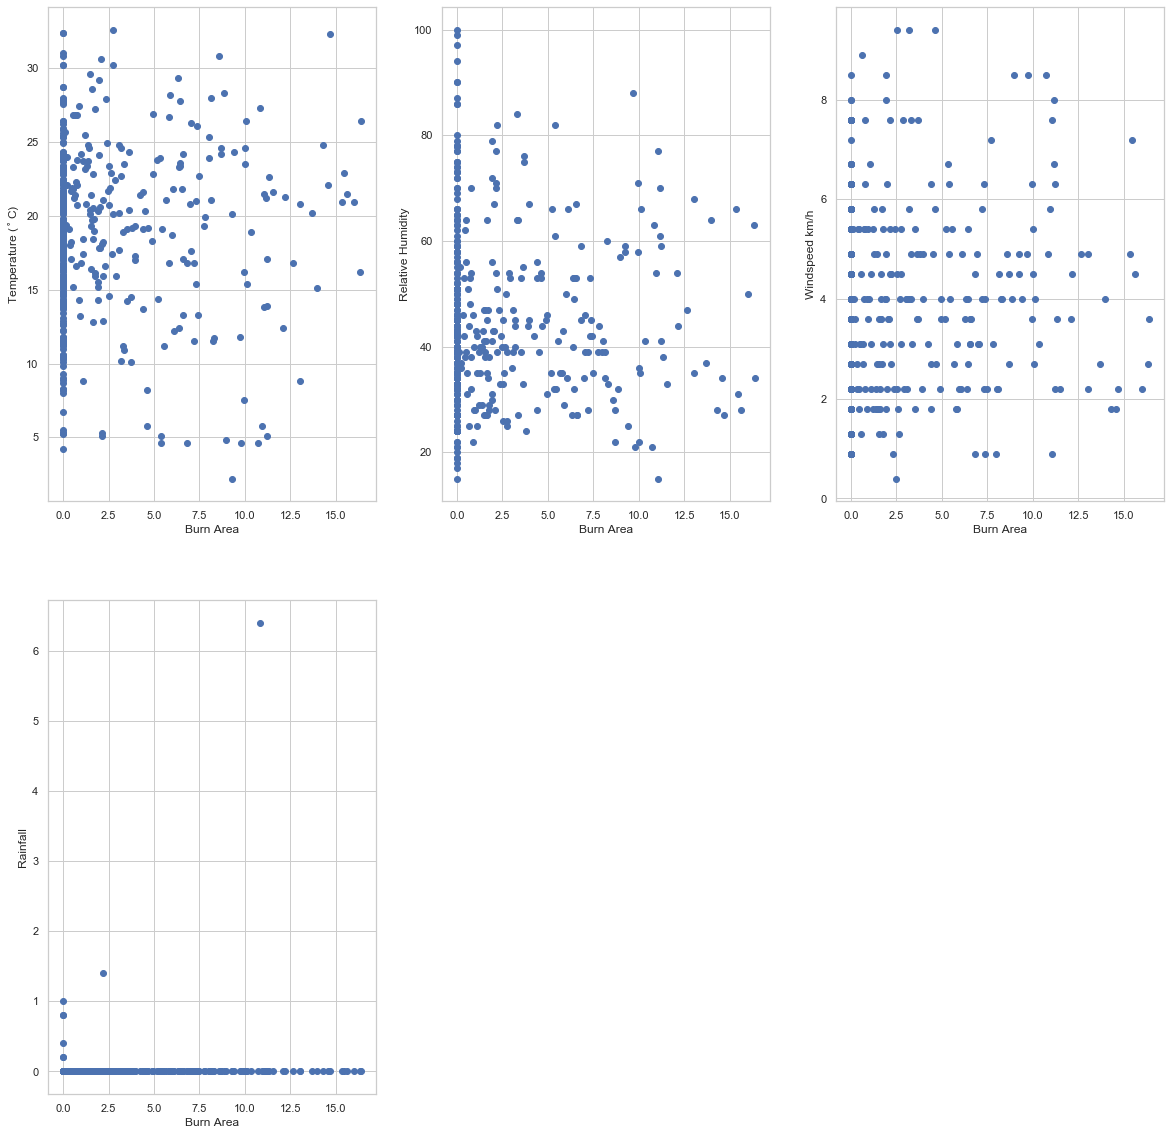


<p>
<table>
    <tr>
        <th></th>
        <th>Temp</th>
        <th>Relative Humidity</th>
        <th>Wind</th>
        <th>Rain</th>
        <th>Area</th>        
    </tr>
    <tr>
        <td>min</td>
        <td>2.2000</td>
        <td>15.0000</td>
        <td>0.4000</td>
        <td>0.0000</td>
        <td>0.0000</td>
    </tr>
    <tr>
        <td>max</td>
        <td>32.6000</td>
        <td>100.0000</td>
        <td>9.4000</td>
        <td>6.4000</td>
        <td>16.4000</td>
    </tr>
    <tr>
        <td>mean</td>
        <td>18.8590</td>
        <td>44.6366</td>
        <td>3.9696</td>
        <td>0.0247</td>
        <td>2.3318</td>
    </tr>
    <tr>
        <td>median</td>
        <td>19.2500</td>
        <td>42.0000</td>
        <td>4.0000</td>
        <td>0.0000</td>
        <td>0.0000</td>
    </tr>
    <tr>
        <td>mode</td>
        <td>17.4</td>
        <td>27</td>
        <td>2.2</td>
        <td>0.0</td>
        <td>0.0</td>
    </tr>
    <tr>
        <td>range</td>
        <td>30.4000</td>
        <td>85.0000</td>
        <td>9.0000</td>
        <td>6.4000</td>
        <td>16.4000</td>
    </tr>
    <tr>
        <td>variance</td>
        <td>32.5900</td>
        <td>264.3811</td>
        <td>3.1545</td>
        <td>0.0995</td>
        <td>14.2652</td>
    </tr>
    <tr>
        <td>std_dev</td>
        <td>5.7088</td>
        <td>16.2598</td>
        <td>1.7761</td>
        <td>0.3154</td>
        <td>3.7769</td>
    </tr>
    <tr>
        <td>std_err</td>
        <td>0.2682</td>
        <td>0.7640</td>
        <td>0.0834</td>
        <td>0.0148</td>
        <td>0.1775</td>        
    </tr>
    <tr>
        <td>q1</td>
        <td>15.5000</td>
        <td>33.0000</td>
        <td>2.7000</td>
        <td>0.0000</td>
        <td>0.0000</td>
    </tr>
    <tr>
        <td>q2</td>
        <td>19.2500</td>
        <td>42.0000</td>
        <td>4.0000</td>
        <td>0.0000</td>
        <td>0.0000</td>
    </tr>
    <tr>
        <td>q3</td>
        <td>22.8000</td>
        <td>53.7500</td>
        <td>4.9000</td>
        <td>0.0000</td>
        <td>3.1975</td>
    </tr>
    <tr>
        <td>IQR</td>
        <td>7.3000</td>
        <td>20.7500</td>
        <td>2.2000</td>
        <td>0.0000</td>
        <td>3.1975</td>
    </tr>
</table>
</p>


In [29]:
# Remove burn area outliers
forest_fires2 = forest_fires[forest_fires['area']<16.425]

quartile_dict = forest_fires2.quantile([0.25,0.5,0.75]).to_dict()
# temp
temp_stats = dict(temp_min=forest_fires2['temp'].min(), 
                  temp_max=forest_fires2['temp'].max(), 
                  temp_mean=forest_fires2['temp'].mean(), 
                  temp_median=forest_fires2['temp'].median(), 
                  temp_mode=forest_fires2['temp'].mode(), 
                  temp_range=np.ptp(forest_fires2['temp']), 
                  temp_variance=np.var(forest_fires2['temp']), 
                  temp_st_dev=np.std(forest_fires2['temp']), 
                  temp_std_err=stats.sem(forest_fires2['temp']), 
                  temp_q1=quartile_dict['temp'][0.25], 
                  temp_q2=quartile_dict['temp'][0.5], 
                  temp_q3=quartile_dict['temp'][0.75], 
                  temp_iqr=quartile_dict['temp'][0.75]-quartile_dict['temp'][0.25])

# Relative Humidity
rh_stats = dict(rh_min=forest_fires2['RH'].min(), 
                  rh_max=forest_fires2['RH'].max(), 
                  rh_mean=forest_fires2['RH'].mean(), 
                  rh_median=forest_fires2['RH'].median(), 
                  rh_mode=forest_fires2['RH'].mode(), 
                  rh_range=np.ptp(forest_fires2['RH']), 
                  rh_variance=np.var(forest_fires2['RH']), 
                  rh_st_dev=np.std(forest_fires2['RH']), 
                  rh_std_err=stats.sem(forest_fires2['RH']), 
                  rh_q1=quartile_dict['RH'][0.25], 
                  rh_q2=quartile_dict['RH'][0.5], 
                  rh_q3=quartile_dict['RH'][0.75], 
                  rh_iqr=quartile_dict['RH'][0.75]-quartile_dict['RH'][0.25])

# wind
wind_stats = dict(wind_min=forest_fires2['wind'].min(), 
                  wind_max=forest_fires2['wind'].max(), 
                  wind_mean=forest_fires2['wind'].mean(), 
                  wind_median=forest_fires2['wind'].median(), 
                  wind_mode=forest_fires2['wind'].mode(), 
                  wind_range=np.ptp(forest_fires2['wind']), 
                  wind_variance=np.var(forest_fires2['wind']), 
                  wind_st_dev=np.std(forest_fires2['wind']), 
                  wind_std_err=stats.sem(forest_fires2['wind']), 
                  wind_q1=quartile_dict['wind'][0.25], 
                  wind_q2=quartile_dict['wind'][0.5], 
                  wind_q3=quartile_dict['wind'][0.75], 
                  wind_iqr=quartile_dict['wind'][0.75]-quartile_dict['wind'][0.25])

# rain
rain_stats = dict(rain_min=forest_fires2['rain'].min(), 
                  rain_max=forest_fires2['rain'].max(), 
                  rain_mean=forest_fires2['rain'].mean(), 
                  rain_median=forest_fires2['rain'].median(), 
                  rain_mode=forest_fires2['rain'].mode(), 
                  rain_range=np.ptp(forest_fires2['rain']), 
                  rain_variance=np.var(forest_fires2['rain']), 
                  rain_st_dev=np.std(forest_fires2['rain']), 
                  rain_std_err=stats.sem(forest_fires2['rain']), 
                  rain_q1=quartile_dict['rain'][0.25], 
                  rain_q2=quartile_dict['rain'][0.5], 
                  rain_q3=quartile_dict['rain'][0.75], 
                  rain_iqr=quartile_dict['rain'][0.75]-quartile_dict['rain'][0.25])

# area
area_stats = dict(area_min=forest_fires2['area'].min(), 
                  area_max=forest_fires2['area'].max(), 
                  area_mean=forest_fires2['area'].mean(), 
                  area_median=forest_fires2['area'].median(), 
                  area_mode=forest_fires2['area'].mode(), 
                  area_range=np.ptp(forest_fires2['area']), 
                  area_variance=np.var(forest_fires2['area']), 
                  area_st_dev=np.std(forest_fires2['area']), 
                  area_std_err=stats.sem(forest_fires2['area']), 
                  area_q1=quartile_dict['area'][0.25], 
                  area_q2=quartile_dict['area'][0.5], 
                  area_q3=quartile_dict['area'][0.75], 
                  area_iqr=quartile_dict['area'][0.75]-quartile_dict['area'][0.25])

plt.figure(figsize=(20,20))

plt.subplot(2,3,1)
plt.scatter(forest_fires2['area'], forest_fires2['temp'])
plt.xlabel('Burn Area')
plt.ylabel('Temperature ($ ^\circ $C)')

plt.subplot(2,3,2)
plt.scatter(forest_fires2['area'], forest_fires2['RH'])
plt.xlabel('Burn Area')
plt.ylabel('Relative Humidity')

plt.subplot(2,3,3)
plt.scatter(forest_fires2['area'], forest_fires2['wind'])
plt.xlabel('Burn Area')
plt.ylabel('Windspeed km/h')

plt.subplot(2,3,4)
plt.scatter(forest_fires2['area'], forest_fires2['rain'])
plt.xlabel('Burn Area')
plt.ylabel('Rainfall')

plt.show()

md(f"""
<p>
<table>
    <tr>
        <th></th>
        <th>Temp</th>
        <th>Relative Humidity</th>
        <th>Wind</th>
        <th>Rain</th>
        <th>Area</th>        
    </tr>
    <tr>
        <td>min</td>
        <td>{temp_stats['temp_min']:.4f}</td>
        <td>{rh_stats['rh_min']:.4f}</td>
        <td>{wind_stats['wind_min']:.4f}</td>
        <td>{rain_stats['rain_min']:.4f}</td>
        <td>{area_stats['area_min']:.4f}</td>
    </tr>
    <tr>
        <td>max</td>
        <td>{temp_stats['temp_max']:.4f}</td>
        <td>{rh_stats['rh_max']:.4f}</td>
        <td>{wind_stats['wind_max']:.4f}</td>
        <td>{rain_stats['rain_max']:.4f}</td>
        <td>{area_stats['area_max']:.4f}</td>
    </tr>
    <tr>
        <td>mean</td>
        <td>{temp_stats['temp_mean']:.4f}</td>
        <td>{rh_stats['rh_mean']:.4f}</td>
        <td>{wind_stats['wind_mean']:.4f}</td>
        <td>{rain_stats['rain_mean']:.4f}</td>
        <td>{area_stats['area_mean']:.4f}</td>
    </tr>
    <tr>
        <td>median</td>
        <td>{temp_stats['temp_median']:.4f}</td>
        <td>{rh_stats['rh_median']:.4f}</td>
        <td>{wind_stats['wind_median']:.4f}</td>
        <td>{rain_stats['rain_median']:.4f}</td>
        <td>{area_stats['area_median']:.4f}</td>
    </tr>
    <tr>
        <td>mode</td>
        <td>{temp_stats['temp_mode'][0]}</td>
        <td>{rh_stats['rh_mode'][0]}</td>
        <td>{wind_stats['wind_mode'][0]}</td>
        <td>{rain_stats['rain_mode'][0]}</td>
        <td>{area_stats['area_mode'][0]}</td>
    </tr>
    <tr>
        <td>range</td>
        <td>{temp_stats['temp_range']:.4f}</td>
        <td>{rh_stats['rh_range']:.4f}</td>
        <td>{wind_stats['wind_range']:.4f}</td>
        <td>{rain_stats['rain_range']:.4f}</td>
        <td>{area_stats['area_range']:.4f}</td>
    </tr>
    <tr>
        <td>variance</td>
        <td>{temp_stats['temp_variance']:.4f}</td>
        <td>{rh_stats['rh_variance']:.4f}</td>
        <td>{wind_stats['wind_variance']:.4f}</td>
        <td>{rain_stats['rain_variance']:.4f}</td>
        <td>{area_stats['area_variance']:.4f}</td>
    </tr>
    <tr>
        <td>std_dev</td>
        <td>{temp_stats['temp_st_dev']:.4f}</td>
        <td>{rh_stats['rh_st_dev']:.4f}</td>
        <td>{wind_stats['wind_st_dev']:.4f}</td>
        <td>{rain_stats['rain_st_dev']:.4f}</td>
        <td>{area_stats['area_st_dev']:.4f}</td>
    </tr>
    <tr>
        <td>std_err</td>
        <td>{temp_stats['temp_std_err']:.4f}</td>
        <td>{rh_stats['rh_std_err']:.4f}</td>
        <td>{wind_stats['wind_std_err']:.4f}</td>
        <td>{rain_stats['rain_std_err']:.4f}</td>
        <td>{area_stats['area_std_err']:.4f}</td>        
    </tr>
    <tr>
        <td>q1</td>
        <td>{temp_stats['temp_q1']:.4f}</td>
        <td>{rh_stats['rh_q1']:.4f}</td>
        <td>{wind_stats['wind_q1']:.4f}</td>
        <td>{rain_stats['rain_q1']:.4f}</td>
        <td>{area_stats['area_q1']:.4f}</td>
    </tr>
    <tr>
        <td>q2</td>
        <td>{temp_stats['temp_q2']:.4f}</td>
        <td>{rh_stats['rh_q2']:.4f}</td>
        <td>{wind_stats['wind_q2']:.4f}</td>
        <td>{rain_stats['rain_q2']:.4f}</td>
        <td>{area_stats['area_q2']:.4f}</td>
    </tr>
    <tr>
        <td>q3</td>
        <td>{temp_stats['temp_q3']:.4f}</td>
        <td>{rh_stats['rh_q3']:.4f}</td>
        <td>{wind_stats['wind_q3']:.4f}</td>
        <td>{rain_stats['rain_q3']:.4f}</td>
        <td>{area_stats['area_q3']:.4f}</td>
    </tr>
    <tr>
        <td>IQR</td>
        <td>{temp_stats['temp_iqr']:.4f}</td>
        <td>{rh_stats['rh_iqr']:.4f}</td>
        <td>{wind_stats['wind_iqr']:.4f}</td>
        <td>{rain_stats['rain_iqr']:.4f}</td>
        <td>{area_stats['area_iqr']:.4f}</td>
    </tr>
</table>
</p>
""")

<h3>Conclusions</h3>
<p>
<em>Based on the data presented, is there a demonstrable link between burn area and environmental conditions?</em><br />
No, not from what I can determine.  The majority of fires are "small" in size.  These are conditions that exist at the time of the fire itself.  This is where the unstudied indexes come into play.  Those indexes take a longitudinal approach that are better indicators for the risk of a fire outbreak but are not predictive of the size of the fire.  
</p>
<p>
<em>Does a statistical analysis buttress or refute a relationship?</em><br />
I do not believe that the statistical breakdown indicates a relationship between burn area and environmental conditions.  None of the environmental factors sit outside the normal range for each axis.  
</p>
<p>
<em>Do the environmental factors have an impact on the burn area?</em><br />
No, not with the analysis restristricted to the environmental conditions that exsit at the time of the fire event.  The environmental conditions only set the stage for the fire events.  That being said, these conditions do not have an impact on the final burn area of the fire. 
</p>
<p>
There are some flaws with this dat set.  Even with over 500 entries the data is restricted to a small geographic location and from a controled environment.  After removing outliers the data set is further reduced and is even less representitive.  
</p>